# Tarea 6. Distribución óptima de capital y selección de portafolios.

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/en/f/f3/SML-chart.png" width="400px" height="400px" />

**Resumen.**
> En esta tarea, tendrás la oportunidad de aplicar los conceptos y las herramientas que aprendimos en el módulo 3. Específicamente, utilizarás técnicas de optimización media-varianza para construir la frontera de mínima varianza, encontrar el mejor portafolio sobre la frontera mínima varianza, y finalmente, identificar la asignación óptima de capital para un inversionista dado su nivel de averisón al riesgo.

**Criterio de revisión.**
> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

**Antes de comenzar.**
> Por favor, copiar y pegar este archivo en otra ubicación. Antes de comenzar, nombrarlo *Tarea6_ApellidoNombre*, sin acentos y sin espacios; por ejemplo, en mi caso el archivo se llamaría *Tarea6_JimenezEsteban*. Resolver todos los puntos en dicho archivo y subir en este espacio.

## 1. Datos (10 puntos)

Considere los siguientes datos de bonos, índice de acciones, mercados desarrollados, mercados emergentes, fondos privados, activos reales y activos libres de riesgo:

In [182]:
# Importamos pandas y numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [183]:
# Resumen en base anual de rendimientos esperados y volatilidades
annual_ret_summ = pd.DataFrame(columns=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real', 'Libre_riesgo'], index=['Media', 'Volatilidad'])
annual_ret_summ.loc['Media'] = np.array([0.0400, 0.1060, 0.0830, 0.1190, 0.1280, 0.0620, 0.0300])
annual_ret_summ.loc['Volatilidad'] = np.array([0.0680, 0.2240, 0.2210, 0.3000, 0.2310, 0.0680, 0])

annual_ret_summ.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real,Libre_riesgo
Media,0.04,0.106,0.083,0.119,0.128,0.062,0.03
Volatilidad,0.068,0.224,0.221,0.3,0.231,0.068,0


In [184]:
# Matriz de correlación
corr = pd.DataFrame(data= np.array([[1.0000, 0.4000, 0.2500, 0.2000, 0.1500, 0.2000],
                                    [0.4000, 1.0000, 0.7000, 0.6000, 0.7000, 0.2000],
                                    [0.2500, 0.7000, 1.0000, 0.7500, 0.6000, 0.1000],
                                    [0.2000, 0.6000, 0.7500, 1.0000, 0.2500, 0.1500],
                                    [0.1500, 0.7000, 0.6000, 0.2500, 1.0000, 0.3000],
                                    [0.2000, 0.2000, 0.1000, 0.1500, 0.3000, 1.0000]]),
                    columns=annual_ret_summ.columns[:-1], index=annual_ret_summ.columns[:-1])
corr.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real
Bonos,1.00,0.4,0.25,0.20,0.15,0.20
Acciones,0.40,1.0,0.70,0.60,0.70,0.20
Desarrollado,0.25,0.7,1.00,0.75,0.60,0.10
Emergente,0.20,0.6,0.75,1.00,0.25,0.15
Privados,0.15,0.7,0.60,0.25,1.00,0.30
Real,0.20,0.2,0.10,0.15,0.30,1.00


1. Graficar en el espacio de rendimiento esperado contra volatilidad cada uno de los activos (10 puntos).

In [185]:
x = annual_ret_summ.loc['Volatilidad']
y = annual_ret_summ.loc['Media']

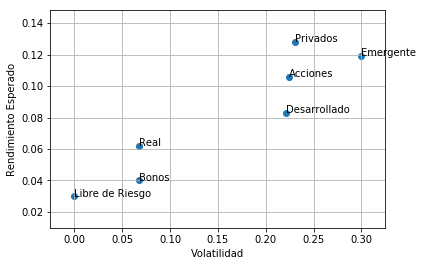

In [186]:
plt.scatter(x,y)
plt.ylabel('Rendimiento Esperado')
plt.xlabel('Volatilidad')

plt.text(x[0],y[0],'Bonos')
plt.text(x[1],y[1],'Acciones')
plt.text(x[2],y[2],'Desarrollado')
plt.text(x[3],y[3],'Emergente')
plt.text(x[4],y[4],'Privados')
plt.text(x[5],y[5],'Real')
plt.text(x[6],y[6],'Libre de Riesgo')

plt.grid()

## 2. Hallando portafolios sobre la frontera de mínima varianza (35 puntos)

Usando los datos del punto anterior:

1. Halle los pesos del portafolio de mínima varianza considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
2. Halle los pesos del portafolio EMV considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
3. Halle la covarianza y la correlación entre los dos portafolios hallados (5 puntos)

In [187]:
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza
s = np.diag(annual_ret_summ.loc['Volatilidad',['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real']])
sigma = s.dot(corr).dot(s)
# 2. Eind: rendimientos esperados activos individuales
Eind = annual_ret_summ.loc['Media',['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real']].values
Eind

array([0.04, 0.106, 0.083, 0.119, 0.128, 0.062], dtype=object)

In [188]:
# Función objetivo
def var(w, sigma):
    return w.dot(sigma).dot(w)

In [189]:
# Dato inicial
n = len(Eind)
w0 = np.ones((n,))/n
# Cotas de las variables
bnds = ((0,1),)*n
# Restricciones
cons = {'type':'eq', 'fun': lambda w: w.sum()-1}

In [190]:
# Portafolio de mínima varianza
minvar = minimize(fun=var, x0=w0, args=(sigma,), bounds=bnds, constraints = cons)
minvar

     fun: 0.0027745037325952863
     jac: array([0.00551408, 0.00912289, 0.00525779, 0.00714968, 0.00710235,
       0.0055834 ])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([4.95146500e-01, 0.00000000e+00, 2.09837058e-04, 4.33680869e-19,
       0.00000000e+00, 5.04643663e-01])

In [191]:
# Rendimiento esperado
w_minvar = minvar.x
E_minvar = np.sum(w_minvar*Eind)
E_minvar

0.0511111835712562

In [192]:
# Volatilidad:
s_minvar = var(w_minvar,sigma)**.5
s_minvar

0.0526735581918982

In [193]:
# Ratio de Sharpe
rf = annual_ret_summ.loc['Media','Libre_riesgo']
RS = (E_minvar - rf) /s_minvar
RS

0.4007928132431225

In [194]:
def menos_RS(w, Eind, sigma , rf):
    Ep = Eind.dot(w)
    sp = np.sqrt(w.dot(sigma).dot(w))
    RS = (Ep - rf) /sp
    return -RS

In [195]:
# Dato inicial
w0 = np.ones((n,)) / n
# Cotas de las variables
bnds = ((0,1),) * n
# Restricciones
cons = {'type':'eq', 'fun': lambda w: w.sum()-1}

In [196]:
# Portafolio EMV
EMV = minimize(fun=menos_RS, x0=w0, args=(Eind, sigma , rf), bounds=bnds, constraints = cons)
EMV

     fun: -0.5811986201269204
     jac: array([-0.36522095, -0.28920724, -0.12258474, -0.36597763, -0.36617207,
       -0.36620118])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.34289953e-17, 1.01738175e-16, 1.23637069e-16, 8.19187951e-02,
       1.65859031e-01, 7.52222174e-01])

In [197]:
# Pesos, rendimiento y riesgo del portafolio EMV
w_EMV = EMV.x
E_EMV = Eind.dot(w_EMV)
s_EMV = np.sqrt(var(w_EMV,sigma))
RS_EMV = (E_EMV - rf)/ s_EMV
w_EMV, E_EMV, s_EMV, RS_EMV

(array([1.34289953e-17, 1.01738175e-16, 1.23637069e-16, 8.19187951e-02,
        1.65859031e-01, 7.52222174e-01]),
 0.0776160673678556,
 0.0819273579098611,
 0.5811986201269204)

In [198]:
# Covarianza entre los portafolios
s_MV_EMV = w_minvar.dot(sigma).dot(w_EMV)
s_MV_EMV

0.0029818190366882494

In [199]:
# Correlación entre los portafolios
r_MV_EMV = s_MV_EMV / (s_minvar * s_EMV)
r_MV_EMV

0.6909707716261657

## 3. Frontera de mínima varianza y LAC (30 puntos)

Con los portafolios que se encontraron en el punto anterior (de mínima varianza y EMV):

1. Construya la frontera de mínima varianza calculando el rendimiento esperado y volatilidad para varias combinaciones de los anteriores portafolios. Reportar dichas combinaciones en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).
2. También construya la línea de asignación de capital entre el activo libre de riesgo y el portafolio EMV. Reportar las combinaciones de estos activos en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).

In [200]:
# Vector de w
N = 101
w = np.linspace(0,1,N)

In [201]:
# DataFrame de portafolios: 
# 1. Índice: i
# 2. Columnas 1-2: w, 1-w
# 3. Columnas 3-4: E[r], sigma
# 4. Columna 5: Sharpe ratio
front_minvar = pd.DataFrame(index = range(1, N + 1), data = {'w_EMV':w,
                                                            'w_minvar': 1-w,
                                                            'Media': w * E_EMV + (1-w) * E_minvar,
                                                            'Vol': np.sqrt((w * s_EMV)**2 + ((1-w) * s_minvar)**2 + 2 * w * (1-w) * s_MV_EMV)
                                                            }
                           )
front_minvar['RS'] = (front_minvar['Media'] - rf) / front_minvar['Vol']
front_minvar.head(10)

,w_EMV,w_minvar,Media,Vol,RS
1,0.00,1.00,0.051111,0.052674,0.400793
2,0.01,0.99,0.051376,0.052716,0.405496
3,0.02,0.98,0.051641,0.052766,0.410140
4,0.03,0.97,0.051906,0.052822,0.414724
5,0.04,0.96,0.052171,0.052884,0.419245
6,0.05,0.95,0.052436,0.052953,0.423703
7,0.06,0.94,0.052701,0.053029,0.428096
8,0.07,0.93,0.052967,0.053111,0.432424
9,0.08,0.92,0.053232,0.053200,0.436685
10,0.09,0.91,0.053497,0.053295,0.440879


In [202]:
# LAC
sp = np.linspace(0,0.25,101)
w_rf = -sp/(s_EMV)+1
Erp = rf + RS_EMV * sp

In [203]:
# DataFrame de portafolios: 
# 1. Índice: i
# 2. Columnas 1-2: w, 1-w
# 3. Columnas 3-4: E[r], sigma
# 4. Columna 5: Sharpe ratio
lac = pd.DataFrame(index = range(1, N + 1), data = {'w_EMV':1-w_rf,
                                                            'rf': w_rf,
                                                            'Media': Erp,
                                                            'Vol': sp
                                                            }
                           )
lac['RS'] = (lac['Media'] - rf) / lac['Vol']
lac.head(10)

,w_EMV,rf,Media,Vol,RS
1,0.000000,1.000000,0.030000,0.0000,NaN
2,0.030515,0.969485,0.031453,0.0025,0.581199
3,0.061030,0.938970,0.032906,0.0050,0.581199
4,0.091545,0.908455,0.034359,0.0075,0.581199
5,0.122059,0.877941,0.035812,0.0100,0.581199
6,0.152574,0.847426,0.037265,0.0125,0.581199
7,0.183089,0.816911,0.038718,0.0150,0.581199
8,0.213604,0.786396,0.040171,0.0175,0.581199
9,0.244119,0.755881,0.041624,0.0200,0.581199
10,0.274634,0.725366,0.043077,0.0225,0.581199


## 4. Gráficos y conclusiones (25 puntos)

1. Usando todos los datos obtenidos, grafique:
 - los activos individuales,
 - portafolio de mínima varianza,
 - portafolio eficiente en media-varianza (EMV),
 - frontera de mínima varianza, y
 - línea de asignación de capital,
en el espacio de rendimiento (eje $y$) vs. volatilidad (eje $x$). Asegúrese de etiquetar todo y poner distintos colores para diferenciar los distintos elementos en su gráfico (15 puntos).
2. Suponga que usted está aconsejando a un cliente cuyo coeficiente de aversión al riesgo resultó ser 4. ¿Qué asignación de capital le sugeriría?, ¿qué significa su resultado?(10 puntos)

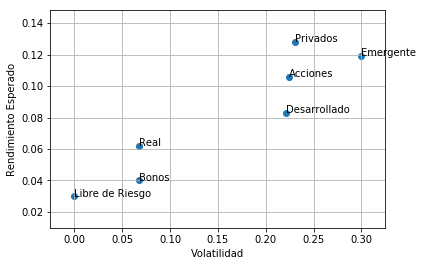

In [204]:
plt.scatter(x,y)
plt.ylabel('Rendimiento Esperado')
plt.xlabel('Volatilidad')

plt.text(x[0],y[0],'Bonos')
plt.text(x[1],y[1],'Acciones')
plt.text(x[2],y[2],'Desarrollado')
plt.text(x[3],y[3],'Emergente')
plt.text(x[4],y[4],'Privados')
plt.text(x[5],y[5],'Real')
plt.text(x[6],y[6],'Libre de Riesgo')

plt.grid()

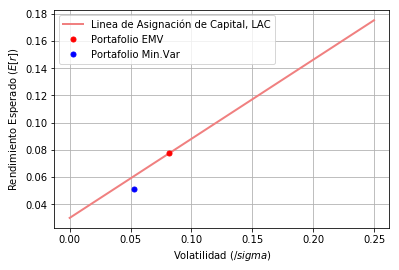

In [205]:
plt.plot(sp,
        Erp,
        lw =2, color='lightcoral', label = 'Linea de Asignación de Capital, LAC')
plt.plot(s_EMV,E_EMV, 'or', ms=5, label='Portafolio EMV')
plt.plot(s_minvar,E_minvar, 'ob', ms=5, label='Portafolio Min.Var')
plt.grid()
plt.xlabel('Volatilidad ($/sigma$)')
plt.ylabel('Rendimiento Esperado ($E[r]$)')
plt.legend(loc = 'best')

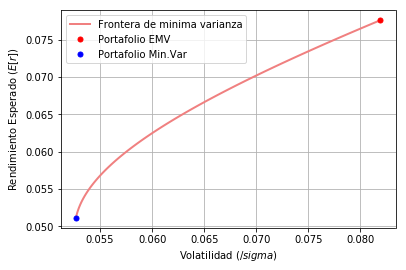

In [206]:
plt.plot(front_minvar['Vol'],
        front_minvar['Media'],
        lw =2, color='lightcoral', label = 'Frontera de minima varianza')
plt.plot(s_EMV,E_EMV, 'or', ms=5, label='Portafolio EMV')
plt.plot(s_minvar,E_minvar, 'ob', ms=5, label='Portafolio Min.Var')
plt.grid()
plt.xlabel('Volatilidad ($/sigma$)')
plt.ylabel('Rendimiento Esperado ($E[r]$)')
plt.legend(loc = 'best')

Text(0,0.03,'Libre de Riesgo')

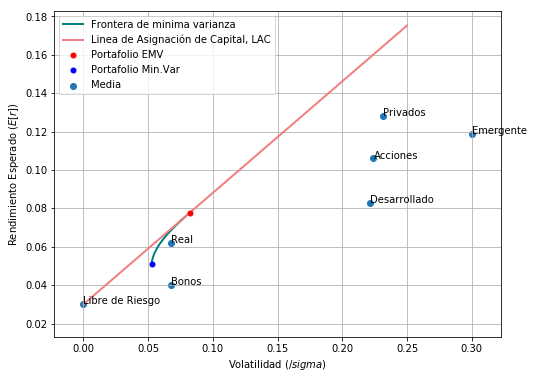

In [207]:
plt.figure(figsize=(8,6))

plt.scatter(x,y)
plt.ylabel('Rendimiento Esperado')
plt.xlabel('Volatilidad')
plt.plot(front_minvar['Vol'],
        front_minvar['Media'],
        lw =2, color='teal', label = 'Frontera de minima varianza')
plt.plot(sp,
        Erp,
        lw =2, color='lightcoral', label = 'Linea de Asignación de Capital, LAC')
plt.plot(s_EMV,E_EMV, 'or', ms=5, label='Portafolio EMV')
plt.plot(s_minvar,E_minvar, 'ob', ms=5, label='Portafolio Min.Var')
plt.grid()
plt.xlabel('Volatilidad ($/sigma$)')
plt.ylabel('Rendimiento Esperado ($E[r]$)')
plt.legend(loc = 'best')

plt.text(x[0],y[0],'Bonos')
plt.text(x[1],y[1],'Acciones')
plt.text(x[2],y[2],'Desarrollado')
plt.text(x[3],y[3],'Emergente')
plt.text(x[4],y[4],'Privados')
plt.text(x[5],y[5],'Real')
plt.text(x[6],y[6],'Libre de Riesgo')


In [208]:
# Para gamma=4
gamma = 4
w_opt = (E_EMV - rf) / (gamma * s_EMV**2)
w_opt

1.7735181353168143

In [222]:
pd.DataFrame(data = np.round(w_EMV*w_opt,3) ,index=[['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real']],columns=['Pct invertido en c/activo'])

,Pct invertido en c/activo
Bonos,0.000
Acciones,0.000
Desarrollado,0.000
Emergente,0.145
Privados,0.294
Real,1.334


Se le sugiere al cliente comprar un 177% de la combinación de activos eficientes con respecto a Media Varianza. Esto último implica que se tiene que realizar una 'venta en corto' o un prestamo a la tasa libre de riesgo (Algo que es 'irreal', ya que no creo que se preste a esta tasa). 

Como se sugiere en la tabla de Pct invertido en cada activo; Se debería invertir el 14% del dinero disponible en mercados emergentes, el 29.4% en Privados y el 133.4% en Real. El excedente al 100% deberá ser subsidiado por el prestamo a la tasa libre de riesgo. 

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>